In [1]:
import numpy as np
import scipy.stats as stats
import scipy.optimize as optimize
from scipy.special import gamma
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
def studentpdf(epsilon, nu):
    if nu <= 2: 
        return 0
    return gamma((nu + 1) / 2) / (gamma(nu / 2) * np.sqrt(np.pi * (nu - 2))) * (1 + epsilon ** 2 / (nu - 2)) ** (-(nu + 1) / 2)

def garch(mu, omega, alpha, beta, returns):
    T = len(returns)
    sigma_squared = np.zeros(T)
    sigma_squared[0] = omega / (1 - alpha - beta)
    for t in range(1, T):
        sigma_squared[t] = omega + alpha * (returns[t - 1] - mu) ** 2 + beta * sigma_squared[t - 1]
    return sigma_squared

def negative_log_likelihood_garch(parameters, returns):
    mu, omega, alpha, beta, nu = parameters
    sigmasquared = garch(mu, omega, alpha, beta, returns)
    epsilon = (returns - mu) / np.sqrt(sigmasquared + 1e-8)
    ll = -np.log(np.sqrt(sigmasquared + 1e-8)) + np.log(studentpdf(epsilon, nu))
    return -np.sum(ll)

In [3]:
def asymmetric_garch(mu, omega, alpha_pos, alpha_neg, beta, returns):
    T = len(returns)
    sigma_squared = np.zeros(T)
    initial_divisor = 1 - beta - alpha_pos / 2 - alpha_neg / 2
    sigma_squared[0] = omega / initial_divisor
    for t in range(1, T):
        epsilon_t = (returns[t-1] - mu)
        shock_effect = alpha_pos * (epsilon_t**2) if epsilon_t >= 0 else alpha_neg * (epsilon_t**2)
        sigma_squared[t] = omega + shock_effect + beta * sigma_squared[t-1]
    return sigma_squared

def neg_log_likelihood_asymmetric_garch(parameters, returns):
    mu, omega, alpha_pos, alpha_neg, beta, nu = parameters
    sigma_squared = asymmetric_garch(mu, omega, alpha_pos, alpha_neg, beta, returns)
    epsilon = (returns - mu) / np.sqrt(sigma_squared + 1e-8)
    ll = -np.log(np.sqrt(sigma_squared + 1e-8)) + np.log(studentpdf(epsilon, nu))
    return -np.sum(ll)

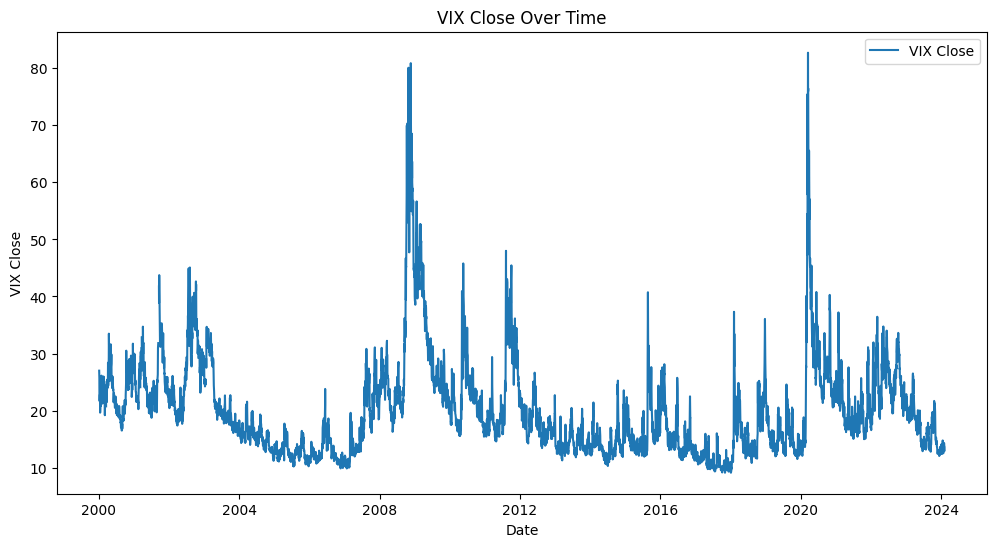

In [4]:
data = pd.read_excel('data.xlsx', index_col='date', parse_dates=True)
returns = data['close-to-close log  return'].values
dates = pd.to_datetime(data.index, format='%Y%m%d')

# Plot VIX
plt.figure(figsize=(12, 6))
plt.plot(data['VIX close'], label='VIX Close')
plt.legend()
plt.title('VIX Close Over Time')
plt.xlabel('Date')
plt.ylabel('VIX Close')
plt.show()


/var/folders/4g/c51vpg2j0nj65hpt4ffnh7xm0000gn/T/ipykernel_96053/615677109.py:17: RuntimeWarning: invalid value encountered in sqrt
  epsilon = (returns - mu) / np.sqrt(sigmasquared + 1e-8)
/var/folders/4g/c51vpg2j0nj65hpt4ffnh7xm0000gn/T/ipykernel_96053/615677109.py:18: RuntimeWarning: invalid value encountered in sqrt
  ll = -np.log(np.sqrt(sigmasquared + 1e-8)) + np.log(studentpdf(epsilon, nu))


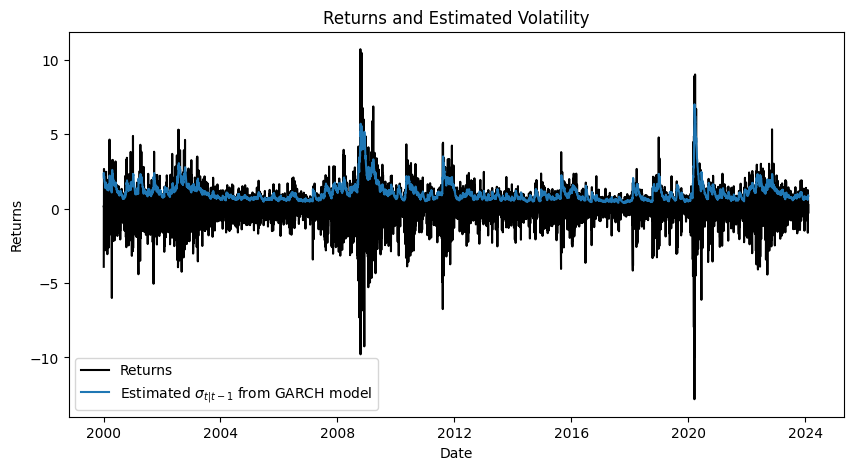

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 8211.260819955009
             x: [ 7.559e-02  1.346e-02  1.212e-01  8.757e-01  6.470e+00]
           nit: 307
          nfev: 505
 final_simplex: (array([[ 7.559e-02,  1.346e-02, ...,  8.757e-01,
                         6.470e+00],
                       [ 7.560e-02,  1.346e-02, ...,  8.757e-01,
                         6.470e+00],
                       ...,
                       [ 7.560e-02,  1.346e-02, ...,  8.757e-01,
                         6.470e+00],
                       [ 7.559e-02,  1.346e-02, ...,  8.757e-01,
                         6.470e+00]]), array([ 8.211e+03,  8.211e+03,  8.211e+03,  8.211e+03,
                        8.211e+03,  8.211e+03]))


In [5]:
# Optimization setup
initial_values = [np.mean(returns), np.var(returns) / 20, 0.10, 0.88, 6]
bounds = [(None, None), (0, None), (0, None), (0, None), (2, 40)]
result = optimize.minimize(negative_log_likelihood_garch, initial_values, args=(returns,), bounds=bounds, method='Nelder-Mead')

# Extract optimized parameters
mu_hat, omega_hat, alpha_hat, beta_hat, nu_hat = result.x
sigmasquared = garch(mu_hat, omega_hat, alpha_hat, beta_hat, returns)

# Plot results
plt.figure(figsize=(10, 5))
plt.plot(dates, returns, 'k', label='Returns')
plt.plot(dates, np.sqrt(sigmasquared), label='Estimated $\sigma_{t|t-1}$ from GARCH model')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Returns')
plt.title('Returns and Estimated Volatility')
plt.show()
print(result)

/var/folders/4g/c51vpg2j0nj65hpt4ffnh7xm0000gn/T/ipykernel_96053/723836336.py:15: RuntimeWarning: invalid value encountered in sqrt
  epsilon = (returns - mu) / np.sqrt(sigma_squared + 1e-8)
/var/folders/4g/c51vpg2j0nj65hpt4ffnh7xm0000gn/T/ipykernel_96053/723836336.py:16: RuntimeWarning: invalid value encountered in sqrt
  ll = -np.log(np.sqrt(sigma_squared + 1e-8)) + np.log(studentpdf(epsilon, nu))


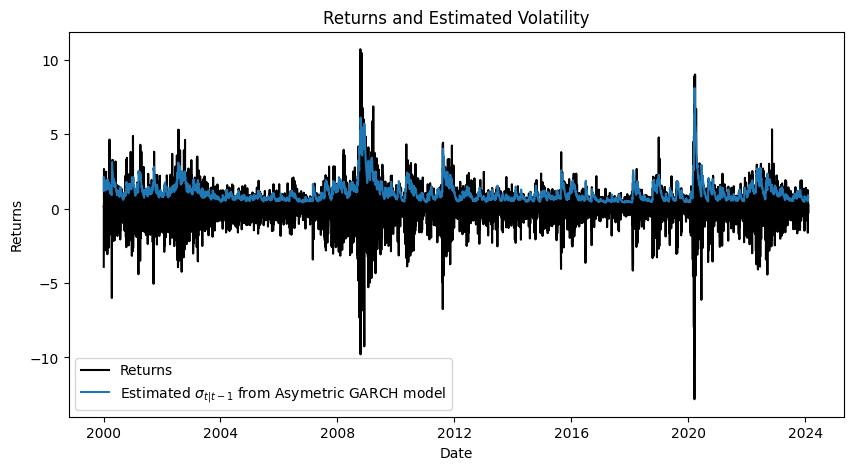

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 8111.406523689524
             x: [ 4.581e-02  1.669e-02  4.752e-06  2.082e-01  8.839e-01
                  6.892e+00]
           nit: 362
          nfev: 569
 final_simplex: (array([[ 4.581e-02,  1.669e-02, ...,  8.839e-01,
                         6.892e+00],
                       [ 4.581e-02,  1.669e-02, ...,  8.839e-01,
                         6.892e+00],
                       ...,
                       [ 4.580e-02,  1.669e-02, ...,  8.839e-01,
                         6.892e+00],
                       [ 4.581e-02,  1.669e-02, ...,  8.839e-01,
                         6.892e+00]]), array([ 8.111e+03,  8.111e+03,  8.111e+03,  8.111e+03,
                        8.111e+03,  8.111e+03,  8.111e+03]))


In [6]:
# Optimization setup
initial_values = [np.mean(returns), np.var(returns) / 20, 0.10, 0.1 , 0.88, 6]
bounds = [(None, None), (0, None), (0, None), (0, None), (0, None), (2, 40)]
result = optimize.minimize(neg_log_likelihood_asymmetric_garch, initial_values, args=(returns,), bounds=bounds, method='Nelder-Mead')

# Extract optimized parameters
mu_hat, omega_hat, alpha_hat_pos, alpha_hat_neg, beta_hat, nu_hat = result.x
sigmasquared = asymmetric_garch(mu_hat, omega_hat, alpha_hat_pos, alpha_hat_neg, beta_hat, returns)

# Plot results
plt.figure(figsize=(10, 5))
plt.plot(dates, returns, 'k', label='Returns')
plt.plot(dates, np.sqrt(sigmasquared), label='Estimated $\sigma_{t|t-1}$ from Asymetric GARCH model')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Returns')
plt.title('Returns and Estimated Volatility')
plt.show()
print(result)

In [7]:
def beta_t_egarch(parameters, returns):
    mu, lam, phi, kappa, k_tilde, nu = parameters
    T = len(returns)
    lambda_t = np.zeros(T)
    lambda_t[0] = lam  # Starting value for lambda

    for t in range(1, T):
        epsilon_t = (returns[t-1] - mu) / np.exp(lambda_t[t-1])
        u_t = np.sqrt((nu + 3) / (2 * nu)) * ((nu + 1) / (nu - 2 + epsilon_t**2) * epsilon_t**2 - 1)
        v_t = np.sqrt(((nu - 2) * (nu + 3)) / (nu * (nu + 1))) * ((nu + 1) / (nu - 2 + epsilon_t**2) * epsilon_t)
        lambda_t[t] = lam * (1 - phi) + phi * lambda_t[t-1] + kappa * u_t + k_tilde * v_t

    sigmas = np.exp(lambda_t)
    return sigmas

def negative_log_likelihood_beta_t_egarch(parameters, returns):
    mu, lam, phi, kappa, k_tilde, nu = parameters
    sigmas = beta_t_egarch(parameters, returns)
    epsilon = (returns - mu) / np.sqrt(sigmas + 1e-8)
    # Using the Student's t-distribution PDF for log likelihood calculation
    #pdf_values = stats.t.pdf(epsilon, df=nu, scale=np.sqrt((nu-2)/nu))
    log_likelihood = -np.log(np.sqrt(sigmas + 1e-8)) + np.log(studentpdf(epsilon, nu))
    return -np.sum(log_likelihood)

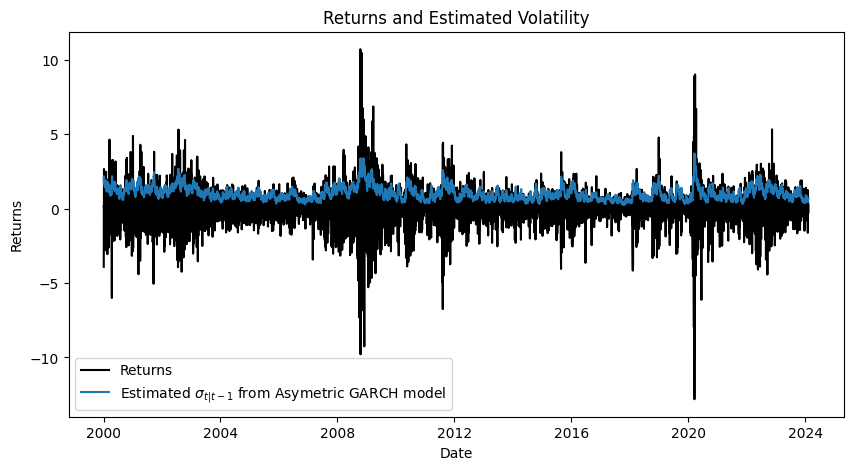

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 8136.393209282867
             x: [ 2.302e-04  1.205e+00  1.000e+00  8.035e-02 -2.205e-01
                  8.264e+00]
           nit: 601
          nfev: 925
 final_simplex: (array([[ 2.302e-04,  1.205e+00, ..., -2.205e-01,
                         8.264e+00],
                       [ 2.304e-04,  1.205e+00, ..., -2.205e-01,
                         8.264e+00],
                       ...,
                       [ 2.306e-04,  1.205e+00, ..., -2.204e-01,
                         8.264e+00],
                       [ 2.306e-04,  1.205e+00, ..., -2.205e-01,
                         8.264e+00]]), array([ 8.136e+03,  8.136e+03,  8.136e+03,  8.136e+03,
                        8.136e+03,  8.136e+03,  8.136e+03]))


In [8]:
# Hypothetical initial parameter values and bounds
initial_values = [np.mean(returns), 0, 0.95, 0.1, 0.1, 6]
bounds = [(None, None), (None, None), (0, 1), (None, None), (None, None), (2, 40)]

result = optimize.minimize(negative_log_likelihood_beta_t_egarch, initial_values, args=(returns,), bounds=bounds, method='Nelder-Mead')

sigmasquared = beta_t_egarch(result.x, returns)

# Plot results
plt.figure(figsize=(10, 5))
plt.plot(dates, returns, 'k', label='Returns')
plt.plot(dates, np.sqrt(sigmasquared), label='Estimated $\sigma_{t|t-1}$ from Asymetric GARCH model')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Returns')
plt.title('Returns and Estimated Volatility')
plt.show()
print(result)